## PROBLEM 7: DBSCAN on real data

In this problem, you will run the DBSCAN algorithm on three real datasets: 20NG, FASHION, and HouseHold. Your task is to implement both phases of DBSCAN (1) neighborhood creation and (2) DBSCAN clustering. You will also evaluate the results and provide an explanation of when and why DBSCAN works and speculate on its limitations.

The datasets you will be using are:

- 20NG dataset: A collection of newsgroup documents categorized into 20 different topics.
- FASHION dataset: A dataset of fashion product images.
- HouseHold dataset: A dataset containing information about household products.

To complete this problem, follow these steps:

1. Obtain the 20NG, FASHION, and HouseHold datasets as per the references provided.
2. Implement the first phase of DBSCAN: neighborhood creation. This involves computing the distance between each pair of data points and identifying the neighboring points within a specified radius (epsilon).
3. Implement the second phase of DBSCAN: clustering. Assign labels to the data points based on their neighborhood relationships and the minimum number of points (MinPts) required to form a dense region.
4. Run DBSCAN on each dataset separately, experimenting with different values of epsilon and MinPts. Use trial and error to find the optimal parameters that yield meaningful clusters.
5. Evaluate the results of DBSCAN by analyzing the clusters formed on each dataset. Consider the distribution of data points, the density of clusters, and the separation between clusters.
6. Provide an explanation of why and when DBSCAN works well on the given datasets. Discuss the characteristics of the datasets that make them suitable for DBSCAN.
7. Speculate on the limitations of DBSCAN and when it may not work effectively. Consider scenarios where the data distribution does not align with the assumptions of DBSCAN or when the parameters are not properly tuned.
8. For extra credit, attempt to improve the DBSCAN runs by curating the datasets using class labels. Remove or add points to create a more suitable set of data for DBSCAN clustering.

By completing this problem, you will gain insights into the application of DBSCAN on real-world datasets and understand its strengths and limitations. Your evaluation and analysis will provide valuable observations about the performance and behavior of DBSCAN on different types of data.

Make sure to refer to the papers mentioned for additional information and insights about DBSCAN.




## 20 NG

In [276]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score as ss
from scipy.sparse import issparse
from sklearn.manifold import TSNE
import plotly.express as px
from matplotlib import pyplot as plt
import pandas as pd

In [277]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Fetch the 20 newsgroups dataset
newsgroups = fetch_20newsgroups(subset='all')

# Split the dataset into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(newsgroups.data, newsgroups.target, train_size=0.20, stratify=newsgroups.target,random_state=42)


# Vectorize the text data into a sparse matrix without common words
max_features = 5000  # Specify the maximum number of features
stop_words = 'english'  # Specify the set of common words
count_vect = CountVectorizer(max_features=max_features, stop_words=stop_words)
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

# Apply TF-IDF transformation
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)


In [278]:
X = X_train_tfidf


In [279]:

# Compute pairwise Euclidean distances
distances = euclidean_distances(X)

# Step 3: Applying DBSCAN on the training set
dbscan = DBSCAN(eps=0.1, min_samples=3, metric='precomputed')

labels = dbscan.fit_predict(distances)
print(labels)
# Print the number of clusters and noise points in the training set
n_train_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_train_noise = list(labels).count(-1)


print("Number of clusters in training set:", n_train_clusters)
print("Number of noise points in training set:", n_train_noise)

# Compute silhouette scores if the number of clusters is greater than 2
if len(set(labels)) > 2:
    score  = ss(X.toarray(),labels)
    print("Score:", score)



[-1 -1 -1 ... -1 -1 -1]
Number of clusters in training set: 0
Number of noise points in training set: 3769


In [280]:
import numpy as np

epsilons = np.linspace(0.01,1.5,num=15)
epsilons

array([0.01      , 0.11642857, 0.22285714, 0.32928571, 0.43571429,
       0.54214286, 0.64857143, 0.755     , 0.86142857, 0.96785714,
       1.07428571, 1.18071429, 1.28714286, 1.39357143, 1.5       ])

In [281]:
min_samples =np.arange(1,15,step=1)
min_samples

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [282]:
import itertools 

combinations = list(itertools.product(epsilons, min_samples))

In [283]:

def get_scores_and_labels(combinations, X, k=1):
    """
    Perform DBSCAN clustering using different combinations of parameters and compute silhouette scores.

    Parameters:
        combinations (list): List of tuples representing different combinations of (eps, min_samples) parameters.
        X (array-like): Input data to be clustered.
        k (int): Number of clusters desired.

    Returns:
        dict: A dictionary containing the best parameters, labels, and score.

    """

    scores = []
    all_labels_lists = []

    for i, (eps, num_samples) in enumerate(combinations):
        dbscan_model = DBSCAN(eps=eps, min_samples=num_samples, metric='euclidean')
        labels = dbscan_model.fit(X).labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1

        if num_clusters < 2 or num_clusters > k:
            scores.append(-10)
            all_labels_lists.append('bad')
            c = (eps, num_samples)
            print(f'combinations {c} {i + 1} of {len(combinations)} has {num_clusters} clusters. Moving on')
            continue

        all_labels_lists.append(labels)

        if issparse(X):
            score = ss(X.toarray(), labels)
        else:
            score = ss(X, labels)

        scores.append(score)
        print(f'Index: {i}, Combination: {eps}, Number of samples: {num_samples}, Scores: {scores[-1]}, Number of clusters: {num_clusters}')

    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels_lists[best_index]
    best_score = scores[best_index]

    return {'best_epsilon': best_parameters[0],
            'best_min_samples': best_parameters[1],
            'best_labels': best_labels,
            'best_score': best_score}


In [284]:
best_dict = get_scores_and_labels(combinations,X,20)

combinations (0.01, 1) 1 of 210 has 3767 clusters. Moving on
Index: 1, Combination: 0.01, Number of samples: 2, Scores: -0.003952446194020178, Number of clusters: 2
combinations (0.01, 3) 3 of 210 has 0 clusters. Moving on
combinations (0.01, 4) 4 of 210 has 0 clusters. Moving on
combinations (0.01, 5) 5 of 210 has 0 clusters. Moving on
combinations (0.01, 6) 6 of 210 has 0 clusters. Moving on
combinations (0.01, 7) 7 of 210 has 0 clusters. Moving on
combinations (0.01, 8) 8 of 210 has 0 clusters. Moving on
combinations (0.01, 9) 9 of 210 has 0 clusters. Moving on
combinations (0.01, 10) 10 of 210 has 0 clusters. Moving on
combinations (0.01, 11) 11 of 210 has 0 clusters. Moving on
combinations (0.01, 12) 12 of 210 has 0 clusters. Moving on
combinations (0.01, 13) 13 of 210 has 0 clusters. Moving on
combinations (0.01, 14) 14 of 210 has 0 clusters. Moving on
combinations (0.11642857142857142, 1) 15 of 210 has 3763 clusters. Moving on
Index: 15, Combination: 0.11642857142857142, Number 

In [285]:
print(best_dict)

{'best_epsilon': 0.6485714285714286, 'best_min_samples': 4, 'best_labels': array([-1, -1, -1, ..., -1, -1, -1], dtype=int64), 'best_score': 0.006154150798220846}


In [286]:
# Step 4: Apply DBSCAN
eps = best_dict['best_epsilon']
min_samples = best_dict['best_min_samples']

dbscan = DBSCAN(eps=eps, min_samples=min_samples,metric='euclidean')
dbscan.fit(X)

labels = dbscan.labels_
unique_labels,counts = np.unique(labels,return_counts=True)

# Print the label counts
for label, count in zip(unique_labels, counts):
    print("Label:", label, "Count:", count)

Label: -1 Count: 3760
Label: 0 Count: 4
Label: 1 Count: 5


In [287]:
X

<3769x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 291764 stored elements in Compressed Sparse Row format>

In [288]:
# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X.toarray())

In [289]:
# Plot the t-SNE visualization
fig = px.scatter(X_tsne[:, 0], X_tsne[:, 1], color=labels)
fig.update_layout(title = "t-SNE Visualization of 20 Newsgroups Dataset")
fig.show()

#### DBSCAN, as a density-based algorithm, is primarily designed for continuous numerical data, such as spatial or geographical data. It measures density based on the distances between data points. Since the 20ng dataset is text data represented as vectors, applying DBSCAN directly to the dataset may not be appropriate without appropriate data preprocessing.

## FASHION dataset

In [290]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml

# Step 1: Load the Fashion-MNIST dataset
fashion_mnist = fetch_openml(name='Fashion-MNIST',parser='auto')


In [291]:

X_train, X_test, y_train, y_test = train_test_split(fashion_mnist.data, fashion_mnist.target, test_size=0.8, stratify=fashion_mnist.target, random_state=42)

X = X_train
y = y_train

# Step 2: Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [292]:
np.unique(y.values)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [293]:
X_pca.shape

(14000, 2)

In [294]:
# Plot the t-SNE visualization
fig = px.scatter(X_pca[:, 0], X_pca[:, 1], color=y.values)
fig.update_layout(title = "DBSCAN Clustering of Fashion-MNIST Dataset")
fig.show()

In [295]:
# Compute pairwise Euclidean distances
distances = euclidean_distances(X_scaled)

# Step 3: Applying DBSCAN on the training set
dbscan = DBSCAN(eps=0.1, min_samples=3, metric='precomputed')

labels = dbscan.fit_predict(distances)
print(labels)
# Print the number of clusters and noise points in the training set
n_train_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_train_noise = list(labels).count(-1)


print("Number of clusters in training set:", n_train_clusters)
print("Number of noise points in training set:", n_train_noise)

# Compute silhouette scores if the number of clusters is greater than 2
if len(set(labels)) > 2:
    score  = ss(X.toarray(),labels)
    print("Score:", score)

[-1 -1 -1 ... -1 -1 -1]
Number of clusters in training set: 0
Number of noise points in training set: 14000


### Grid search for epsilon and min sample size

In [296]:
X_train.shape

(14000, 784)

In [297]:
best_dict = get_scores_and_labels(combinations,X_scaled,10)

combinations (0.01, 1) 1 of 210 has 14000 clusters. Moving on
combinations (0.01, 2) 2 of 210 has 0 clusters. Moving on
combinations (0.01, 3) 3 of 210 has 0 clusters. Moving on
combinations (0.01, 4) 4 of 210 has 0 clusters. Moving on
combinations (0.01, 5) 5 of 210 has 0 clusters. Moving on
combinations (0.01, 6) 6 of 210 has 0 clusters. Moving on
combinations (0.01, 7) 7 of 210 has 0 clusters. Moving on
combinations (0.01, 8) 8 of 210 has 0 clusters. Moving on
combinations (0.01, 9) 9 of 210 has 0 clusters. Moving on
combinations (0.01, 10) 10 of 210 has 0 clusters. Moving on
combinations (0.01, 11) 11 of 210 has 0 clusters. Moving on
combinations (0.01, 12) 12 of 210 has 0 clusters. Moving on
combinations (0.01, 13) 13 of 210 has 0 clusters. Moving on
combinations (0.01, 14) 14 of 210 has 0 clusters. Moving on
combinations (0.11642857142857142, 1) 15 of 210 has 14000 clusters. Moving on
combinations (0.11642857142857142, 2) 16 of 210 has 0 clusters. Moving on
combinations (0.116428

In [298]:
# Find epsilon and minimum number of components on Fashion dataset pca
best_dict = get_scores_and_labels(combinations,X_pca,10)

combinations (0.01, 1) 1 of 210 has 13966 clusters. Moving on
combinations (0.01, 2) 2 of 210 has 34 clusters. Moving on
combinations (0.01, 3) 3 of 210 has 0 clusters. Moving on
combinations (0.01, 4) 4 of 210 has 0 clusters. Moving on
combinations (0.01, 5) 5 of 210 has 0 clusters. Moving on
combinations (0.01, 6) 6 of 210 has 0 clusters. Moving on
combinations (0.01, 7) 7 of 210 has 0 clusters. Moving on
combinations (0.01, 8) 8 of 210 has 0 clusters. Moving on
combinations (0.01, 9) 9 of 210 has 0 clusters. Moving on
combinations (0.01, 10) 10 of 210 has 0 clusters. Moving on
combinations (0.01, 11) 11 of 210 has 0 clusters. Moving on
combinations (0.01, 12) 12 of 210 has 0 clusters. Moving on
combinations (0.01, 13) 13 of 210 has 0 clusters. Moving on
combinations (0.01, 14) 14 of 210 has 0 clusters. Moving on
combinations (0.11642857142857142, 1) 15 of 210 has 10439 clusters. Moving on
combinations (0.11642857142857142, 2) 16 of 210 has 2031 clusters. Moving on
combinations (0.11

In [299]:
best_dict

{'best_epsilon': 1.2871428571428571,
 'best_min_samples': 8,
 'best_labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'best_score': 0.24653587715932995}

In [300]:
# Step 4: Apply DBSCAN
eps = best_dict['best_epsilon']
min_samples = best_dict['best_min_samples']

dbscan = DBSCAN(eps=eps, min_samples=min_samples,metric='euclidean')
dbscan.fit(X_pca)

labels = dbscan.labels_
unique_labels,counts = np.unique(labels,return_counts=True)

# Print the label counts
for label, count in zip(unique_labels, counts):
    print("Label:", label, "Count:", count)

Label: -1 Count: 182
Label: 0 Count: 13800
Label: 1 Count: 10
Label: 2 Count: 8


In [301]:
# Plot the PCA using best parameters of DBSCana 
fig = px.scatter(X_pca[:, 0], X_pca[:, 1], color=labels)
fig.update_layout(title = "Best Parmeters of DBSCAN Clustering of PCA Fashion-MNIST Dataset")
fig.show()

## Housing dataset

In [302]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Create a StandardScaler object
scaler = StandardScaler()

# Load the California housing dataset
california = fetch_california_housing()

# Create a DataFrame from the data and target variables
df = pd.DataFrame(california.data, columns=california.feature_names)
y = california.target

# Normalize the DataFrame
normalized_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
X_train, X_test, y_train, y_test = train_test_split(normalized_df, y, test_size=0.2, random_state=42)


In [303]:
print(X_train.head())
print(X_train.shape)

         MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
14196 -0.321654  0.346478 -0.166259  -0.190451    0.772251  0.059808   
8267  -0.030620  1.617807 -0.386181  -0.117472   -0.098440 -0.128306   
17445  0.150349 -1.957806  0.087641  -0.235400   -0.450778 -0.033453   
14265 -1.014947  0.584852 -0.576442  -0.132670   -0.006602  0.088940   
2271  -0.166583  1.141059  0.339282   0.079205   -0.486983 -0.074203   

       Latitude  Longitude  
14196 -1.367976   1.267645  
8267  -0.871699   0.703627  
17445 -0.455012  -0.454356  
14265 -1.377340   1.227714  
2271   0.537543  -0.114948  
(16512, 8)


In [304]:
california_distance_matrix = euclidean_distances(X_train)
# Find the maximum and minimum distances
max_distance = np.max(california_distance_matrix, axis=1)
min_distance = np.min(california_distance_matrix, axis=1)

# Print the maximum and minimum distances
print("Maximum distances:", max_distance)
print("Minimum distances:", min_distance)

Maximum distances: [119.56360992 119.75467326 119.69854892 ... 119.59585808 119.57004946
 119.65870297]
Minimum distances: [0. 0. 0. ... 0. 0. 0.]


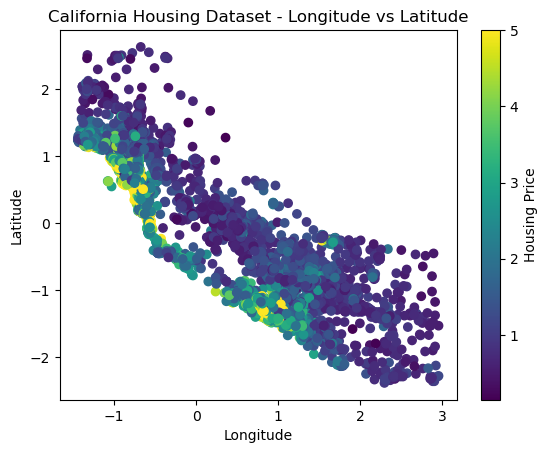

In [305]:
import matplotlib.pyplot as plt

# Plot longitude and latitude
plt.scatter(X_train['Latitude'], X_train['Longitude'], c=y_train)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('California Housing Dataset - Longitude vs Latitude')
plt.colorbar(label='Housing Price')
plt.show()


In [306]:
dbscan_medel = DBSCAN().fit(X_train)


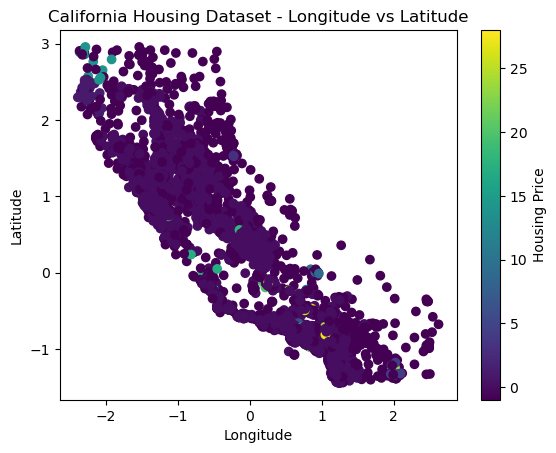

In [307]:
# Plot longitude and latitude
plt.scatter(X_train['Longitude'], X_train['Latitude'], c=dbscan_medel.labels_)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('California Housing Dataset - Longitude vs Latitude')
plt.colorbar(label='Housing Price')
plt.show()

In [308]:
dbscan_medel.labels_

array([ 0,  0, -1, ...,  0,  0,  0], dtype=int64)

In [309]:
epsilons = np.linspace(0.01,120,num=30)

In [310]:
min_samples = np.arange(2,20,step =1)

In [311]:
combinations = list(itertools.product(epsilons, min_samples))

In [312]:
# Find epsilon and minimum number of components on Fashion dataset pca
best_dict = get_scores_and_labels(combinations,X_train)

combinations (0.01, 2) 1 of 540 has 0 clusters. Moving on
combinations (0.01, 3) 2 of 540 has 0 clusters. Moving on
combinations (0.01, 4) 3 of 540 has 0 clusters. Moving on
combinations (0.01, 5) 4 of 540 has 0 clusters. Moving on
combinations (0.01, 6) 5 of 540 has 0 clusters. Moving on
combinations (0.01, 7) 6 of 540 has 0 clusters. Moving on
combinations (0.01, 8) 7 of 540 has 0 clusters. Moving on
combinations (0.01, 9) 8 of 540 has 0 clusters. Moving on
combinations (0.01, 10) 9 of 540 has 0 clusters. Moving on
combinations (0.01, 11) 10 of 540 has 0 clusters. Moving on
combinations (0.01, 12) 11 of 540 has 0 clusters. Moving on
combinations (0.01, 13) 12 of 540 has 0 clusters. Moving on
combinations (0.01, 14) 13 of 540 has 0 clusters. Moving on
combinations (0.01, 15) 14 of 540 has 0 clusters. Moving on
combinations (0.01, 16) 15 of 540 has 0 clusters. Moving on
combinations (0.01, 17) 16 of 540 has 0 clusters. Moving on
combinations (0.01, 18) 17 of 540 has 0 clusters. Moving 

## PCA on Housing dataset

In [ ]:

# Step 3: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

In [ ]:
best_dict = get_scores_and_labels(combinations,X_pca,10)

combinations (0.01, 2) 1 of 540 has 2494 clusters. Moving on
combinations (0.01, 3) 2 of 540 has 944 clusters. Moving on
combinations (0.01, 4) 3 of 540 has 367 clusters. Moving on
combinations (0.01, 5) 4 of 540 has 140 clusters. Moving on
combinations (0.01, 6) 5 of 540 has 41 clusters. Moving on
combinations (0.01, 7) 6 of 540 has 14 clusters. Moving on
Index: 6, Combination: 0.01, Number of samples: 8, Scores: -0.3464879787440034, Number of clusters: 4
combinations (0.01, 9) 8 of 540 has 1 clusters. Moving on
combinations (0.01, 10) 9 of 540 has 1 clusters. Moving on
combinations (0.01, 11) 10 of 540 has 0 clusters. Moving on
combinations (0.01, 12) 11 of 540 has 0 clusters. Moving on
combinations (0.01, 13) 12 of 540 has 0 clusters. Moving on
combinations (0.01, 14) 13 of 540 has 0 clusters. Moving on
combinations (0.01, 15) 14 of 540 has 0 clusters. Moving on
combinations (0.01, 16) 15 of 540 has 0 clusters. Moving on
combinations (0.01, 17) 16 of 540 has 0 clusters. Moving on
co